#  Cheapest day before a flight to buy tickets prediction - Iteration 1

🔙 Summary From Iteraion 0:
- Only routes - SOF - EIN
- KNN ML algorithm
- Base bone dataset
- Low feature correlations but
- Suspicious 99% accuracy
- The model just calculates the target variable but does not predict it

🔜 Summary For Iteraion 1:
- Dataset Improvements
- Higher correlations
- Distance between airports
- Improved code quality
- Better domain understanding
- Linear Regression
- Main problem solving
- Little margin of error


In [1]:
import sklearn
import pandas as pd
import seaborn
import numpy as np
from matplotlib import pyplot as plt
import glob
import seaborn as sns
import matplotlib.pyplot as plt


# 📦 Data provisioning
The flights is gathered from **google flights**, using a *webscraper*. It includes data from the routes **SOF-EIN** , **EIN-SOF** , **EIN-ATH** , **ISTANBUL-AMS** , **MUNICH - NEW YORK**. The dataset includes data from **03.2025 - 12.2025**

In [2]:
csv_files = glob.glob("./datasets/iteration1/*.csv")

original_main_data = pd.concat([pd.read_csv(file, parse_dates=["departureDate", "record_timestamp"], low_memory=False) for file in csv_files], ignore_index=True)

main_data = original_main_data.copy(deep=True)


# 📃 Sample the data


In [3]:
main_data.sample(10)

,daysAgo,departureDate,price,departure_airport,arrival_airport,is_public_holiday,is_school_holiday,airline,near_holiday,record_timestamp
52552,134,2025-06-08,100,New York,"Washington, D.C.",False,False,Delta,NaN,2025-01-25
33193,171,2025-08-19,130,İstanbul,Amsterdam,False,True,Turkish Airlines,1.0,2025-03-01
4079,78,2025-05-30,159,Eindhoven,Athens,False,False,Transavia,1.0,2025-03-13
43014,124,2025-07-13,192,Eindhoven,Sofia,False,True,Wizzair,-1.0,2025-03-11
36188,200,2025-10-06,84,İstanbul,Amsterdam,False,False,Turkish Airlines,-1.0,2025-03-20
45541,201,2025-08-24,52,Eindhoven,Sofia,False,True,Wizzair,-1.0,2025-02-04
34656,220,2025-09-12,109,İstanbul,Amsterdam,False,False,Turkish Airlines,1.0,2025-02-04
9112,186,2025-08-22,85,Eindhoven,Athens,False,True,Transavia,-1.0,2025-02-17
36243,208,2025-10-07,94,İstanbul,Amsterdam,False,False,Pegasus,-1.0,2025-03-13
34699,177,2025-09-12,102,İstanbul,Amsterdam,False,False,Pegasus,1.0,2025-03-19


In [4]:
group_info = main_data.groupby(["departure_airport"])["departure_airport"].count()
group_info

departure_airport
Eindhoven    23845
New York     11848
Sofia        11987
İstanbul     12316
Name: departure_airport, dtype: int64

# 🛠️ Preprocessing 

The step of preprocessing contains several activities to consider before we can start training the algorithm and produce a model that can predict our target variable, in this case the days before a flight, containing the cheapest tickets. 

## 🎯 Target Variable


First, as the algorhitm is categorical, we need to convert the target variable into a category.

In [5]:
import pandas as pd
import numpy as np
import math

bins = [7, 14, 30, 60, 100, 200]  # Upper limits for each category
category_order = [
    'days < 7', '7 <= days < 14', '14 <= days < 30',
    '30 <= days < 60', '60 <= days < 100', '100 <= days < 200', 'days > 200'
]

# Assign categories based on limits
indices = np.digitize(main_data["daysAgo"], bins, right=False)
main_data["daysAgo_category"] = np.array(category_order)[indices]

# Convert to categorical with the specified order
main_data['daysAgo_category'] = pd.Categorical(main_data['daysAgo_category'], categories=category_order, ordered=True)
main_data


,daysAgo,departureDate,price,departure_airport,arrival_airport,is_public_holiday,is_school_holiday,airline,near_holiday,record_timestamp,daysAgo_category
0,65,2025-03-25,80,Eindhoven,Athens,False,False,Transavia,NaN,2025-01-19,60 <= days < 100
1,64,2025-03-25,80,Eindhoven,Athens,False,False,Transavia,NaN,2025-01-20,60 <= days < 100
2,63,2025-03-25,80,Eindhoven,Athens,False,False,Transavia,NaN,2025-01-21,60 <= days < 100
3,62,2025-03-25,88,Eindhoven,Athens,False,False,Aegean,NaN,2025-01-22,60 <= days < 100
4,61,2025-03-25,88,Eindhoven,Athens,False,False,Aegean,NaN,2025-01-23,60 <= days < 100
...,...,...,...,...,...,...,...,...,...,...,...
59991,207,2025-10-09,50,New York,"Washington, D.C.",False,False,Delta,-1.0,2025-03-16,days > 200
59992,206,2025-10-09,50,New York,"Washington, D.C.",False,False,Delta,-1.0,2025-03-17,days > 200
59993,205,2025-10-09,51,New York,"Washington, D.C.",False,False,Delta,-1.0,2025-03-18,days > 200
59994,204,2025-10-09,50,New York,"Washington, D.C.",False,False,Republic American,-1.0,2025-03-19,days > 200


/var/folders/y7/db2_95bs6k9djjfg92g5zmnr0000gn/T/ipykernel_4858/4152313338.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_range = main_data.groupby('daysAgo_category')['price'].mean().reset_index()


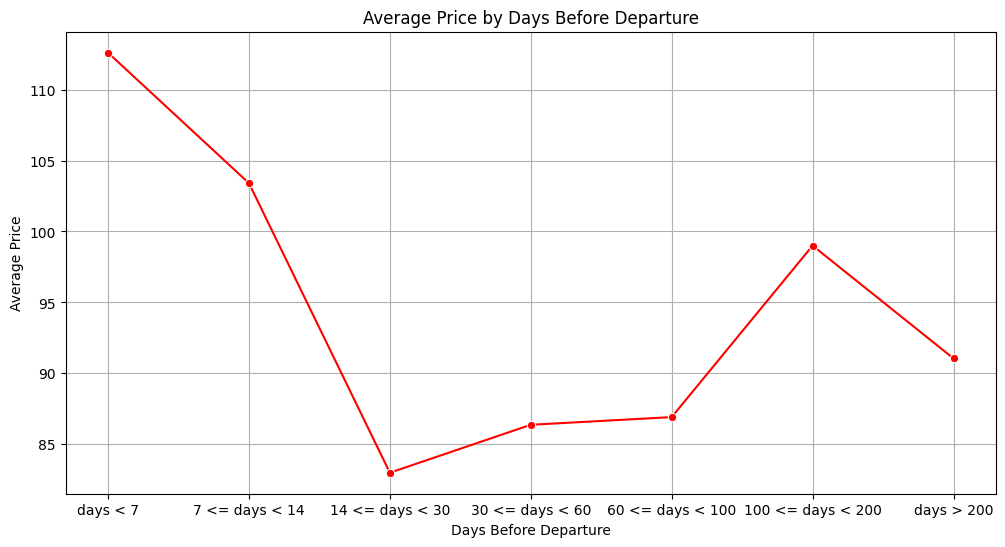

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

avg_price_by_range = main_data.groupby('daysAgo_category')['price'].mean().reset_index()

# Sort the DataFrame by 'daysAgo_category' to ensure the plot uses the correct order
avg_price_by_range = avg_price_by_range.sort_values('daysAgo_category', ascending=True)

# Plotting average price by days range
plt.figure(figsize=(12,6))
sns.lineplot(x='daysAgo_category', y='price', data=avg_price_by_range, marker='o', color='red')

# Adding labels and title
plt.title('Average Price by Days Before Departure')
plt.xlabel('Days Before Departure')
plt.ylabel('Average Price')

# Add grid to the plot
plt.grid(True)

# Show plot
plt.show()

The same graph but with the dataset from iteration 0

![Iteration_0_Graph](https://i.ibb.co/wN5NQ0BJ/output.png)


Conclusion:
- Both graphs confirm that booking less than 7 days before departure results in the highest prices.
-	For EIN–SOF, booking 30–60 days ahead is best, while for multiple routes, 14–30 days offers the lowest prices.
-	Booking too early (100+ days) is not beneficial in either case, especially for EIN–SOF where prices go up sharply.


## Addming new feature - distance between departure and arrival airports

In [7]:
airport_coords = {
    'New York': (40.7128, -74.0060),
    'Amsterdam': (52.3676, 4.9041),
    'Athens': (37.9838, 23.7275),
    'Eindhoven': (51.4416, 5.4697),
    'Sofia': (42.6975, 23.3242),
    'Washington, D.C.': (38.8951, -77.0364),
    'İstanbul': (41.0082, 28.9784)
}

# Function to calculate Haversine distance
# Source: https://stackoverflow.com/questions/25711895/the-result-by-haversine-formula-is-meter-o-kmeter
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in km
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c  # Distance in km

def calculate_distance(row):
    dep = row['departure_airport']
    arr = row['arrival_airport']
    if dep in airport_coords and arr in airport_coords:
        lat1, lon1 = airport_coords[dep]
        lat2, lon2 = airport_coords[arr]
        return haversine_distance(lat1, lon1, lat2, lon2)
    else:
        return None  # Handle missing airport coordinates

main_data['airport_distance_km'] = main_data.apply(calculate_distance, axis=1)
main_data.sample(10)

,daysAgo,departureDate,price,departure_airport,arrival_airport,is_public_holiday,is_school_holiday,airline,near_holiday,record_timestamp,daysAgo_category,airport_distance_km
38328,98,2025-04-28,80,Eindhoven,Sofia,False,True,Wizzair,-1.0,2025-01-20,60 <= days < 100,1658.335311
47425,239,2025-09-24,64,Eindhoven,Sofia,False,False,Other,1.0,2025-01-28,days > 200,1658.335311
49958,61,2025-04-25,53,New York,"Washington, D.C.",False,False,Delta,1.0,2025-02-23,60 <= days < 100,328.393017
2265,94,2025-05-01,129,Eindhoven,Athens,True,True,Transavia,0.0,2025-01-27,60 <= days < 100,2067.423123
47916,244,2025-10-02,90,Eindhoven,Sofia,False,False,Ryanair,NaN,2025-01-31,days > 200,1658.335311
51315,69,2025-05-18,51,New York,"Washington, D.C.",False,False,Republic American,-1.0,2025-03-10,60 <= days < 100,328.393017
44316,186,2025-08-04,104,Eindhoven,Sofia,False,True,Wizzair,-1.0,2025-01-30,100 <= days < 200,1658.335311
39635,93,2025-05-19,56,Eindhoven,Sofia,False,False,Wizzair,-1.0,2025-02-15,60 <= days < 100,1658.335311
55515,148,2025-07-27,114,New York,"Washington, D.C.",False,True,Delta,1.0,2025-03-01,100 <= days < 200,328.393017
31611,180,2025-07-25,111,İstanbul,Amsterdam,False,True,Turkish Airlines,-1.0,2025-01-26,100 <= days < 200,2211.947562


Why One-Hot Encoding the Airline :
1.	Lower Correlation with Other Features – The airline feature does not show strong linear correlations with other features, which suggests that it might not introduce significant redundancy when one-hot encoded.
2.	Categorical Nature of Airlines – Airlines are naturally categorical and one-hot encoding could help preserve distinct airline identities without introducing ordinal relationships that don’t exist.
3.	Potential Interactions – Different airlines may have distinct pricing strategies that one-hot encoding can help capture.

Why Keeping Departure/Arrival Airports as Label Encoded is goode:
1.	Strong Correlation Between Airports – Departure and arrival airports show higher correlations among themselves. This might indicate that the distance between airports (which you could introduce as a feature) could be a more meaningful numerical representation.
2.	High-Dimensionality Risk – One-hot encoding airports can significantly increase the number of features, especially if there are many unique airports. This could make training less efficient and introduce sparsity issues

Then, we need to convert the respectable non numerical values (airports and holidays) into numberical values

In [8]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
main_data["daysAgo_category_id"] = encoder.fit_transform(main_data["daysAgo_category"])
main_data.drop(columns=['daysAgo_category'], inplace=True)

# Perform one-hot encoding on 'airline' and label encoding on airports
main_data = pd.get_dummies(main_data, columns=['airline'])

cols_to_convert = main_data.columns[-9:]  # Select the last 9 columns, which are one-hot encoded
main_data[cols_to_convert] = main_data[cols_to_convert].astype(int)  # Convert True/False to 0/1

main_data['departure_date_unix'] = main_data['departureDate'].astype('int64') // 10**9
main_data['record_timestamp_unix'] = main_data['record_timestamp'].astype('int64') // 10**9
main_data = pd.get_dummies(main_data, columns=['near_holiday']) # as the columns is -1, 0, 1 which messes with the algorithm

main_data["departure_airport"] = encoder.fit_transform(main_data["departure_airport"])
main_data["arrival_airport"] = encoder.fit_transform(main_data["arrival_airport"])

#removing these columns as the  "near_holiday" has the same purpose

main_data.drop(columns=['is_public_holiday'], inplace=True)
main_data.drop(columns=['is_school_holiday'], inplace=True)

#removing these colums as they are converted to unix
main_data.drop(columns=['departureDate'], inplace=True)
main_data.drop(columns=['record_timestamp'], inplace=True)

col = main_data.pop("daysAgo_category_id")  # Remove the column

main_data_prepared = main_data.copy(deep=True)
main_data.insert(0, "daysAgo_category_id", col)  # Insert it at 0

#Removing the column daysAgo as this attempt will be categorical
main_data.drop(columns=['daysAgo'], inplace=True)

main_data.sample(10)

,daysAgo_category_id,price,departure_airport,arrival_airport,airport_distance_km,airline_Aegean,airline_Delta,airline_Other,airline_Pegasus,airline_Republic American,airline_Ryanair,airline_Transavia,airline_Turkish Airlines,airline_Wizzair,departure_date_unix,record_timestamp_unix,near_holiday_-1.0,near_holiday_0.0,near_holiday_1.0
3505,3,129,0,1,2067.423123,0,0,0,0,0,0,1,0,0,1747785600,1739664000,True,False,False
50908,0,91,1,4,328.393017,0,1,0,0,0,0,0,0,0,1747008000,1738022400,False,False,True
57372,0,42,1,4,328.393017,0,0,1,0,0,0,0,0,0,1756252800,1742428800,False,True,False
44882,0,73,0,3,1658.335311,0,0,1,0,0,0,0,0,0,1755043200,1739664000,False,False,True
55831,0,51,1,4,328.393017,0,1,0,0,0,0,0,0,0,1754006400,1741737600,True,False,False
11343,6,111,0,1,2067.423123,0,0,0,0,0,0,1,0,0,1759017600,1737504000,False,False,True
5510,0,76,0,1,2067.423123,1,0,0,0,0,0,0,0,0,1750636800,1738972800,False,False,False
43005,0,207,0,3,1658.335311,0,0,0,0,0,0,0,0,1,1752364800,1740873600,True,False,False
4667,0,94,0,1,2067.423123,0,0,0,0,0,0,1,0,0,1749427200,1739923200,False,False,False
25410,2,105,3,0,2211.947562,0,0,0,0,0,0,0,1,0,1744675200,1741737600,True,False,False


### 💡 Feature Selection

Now we will create several graphs to visualize relationships between the features of the dataset


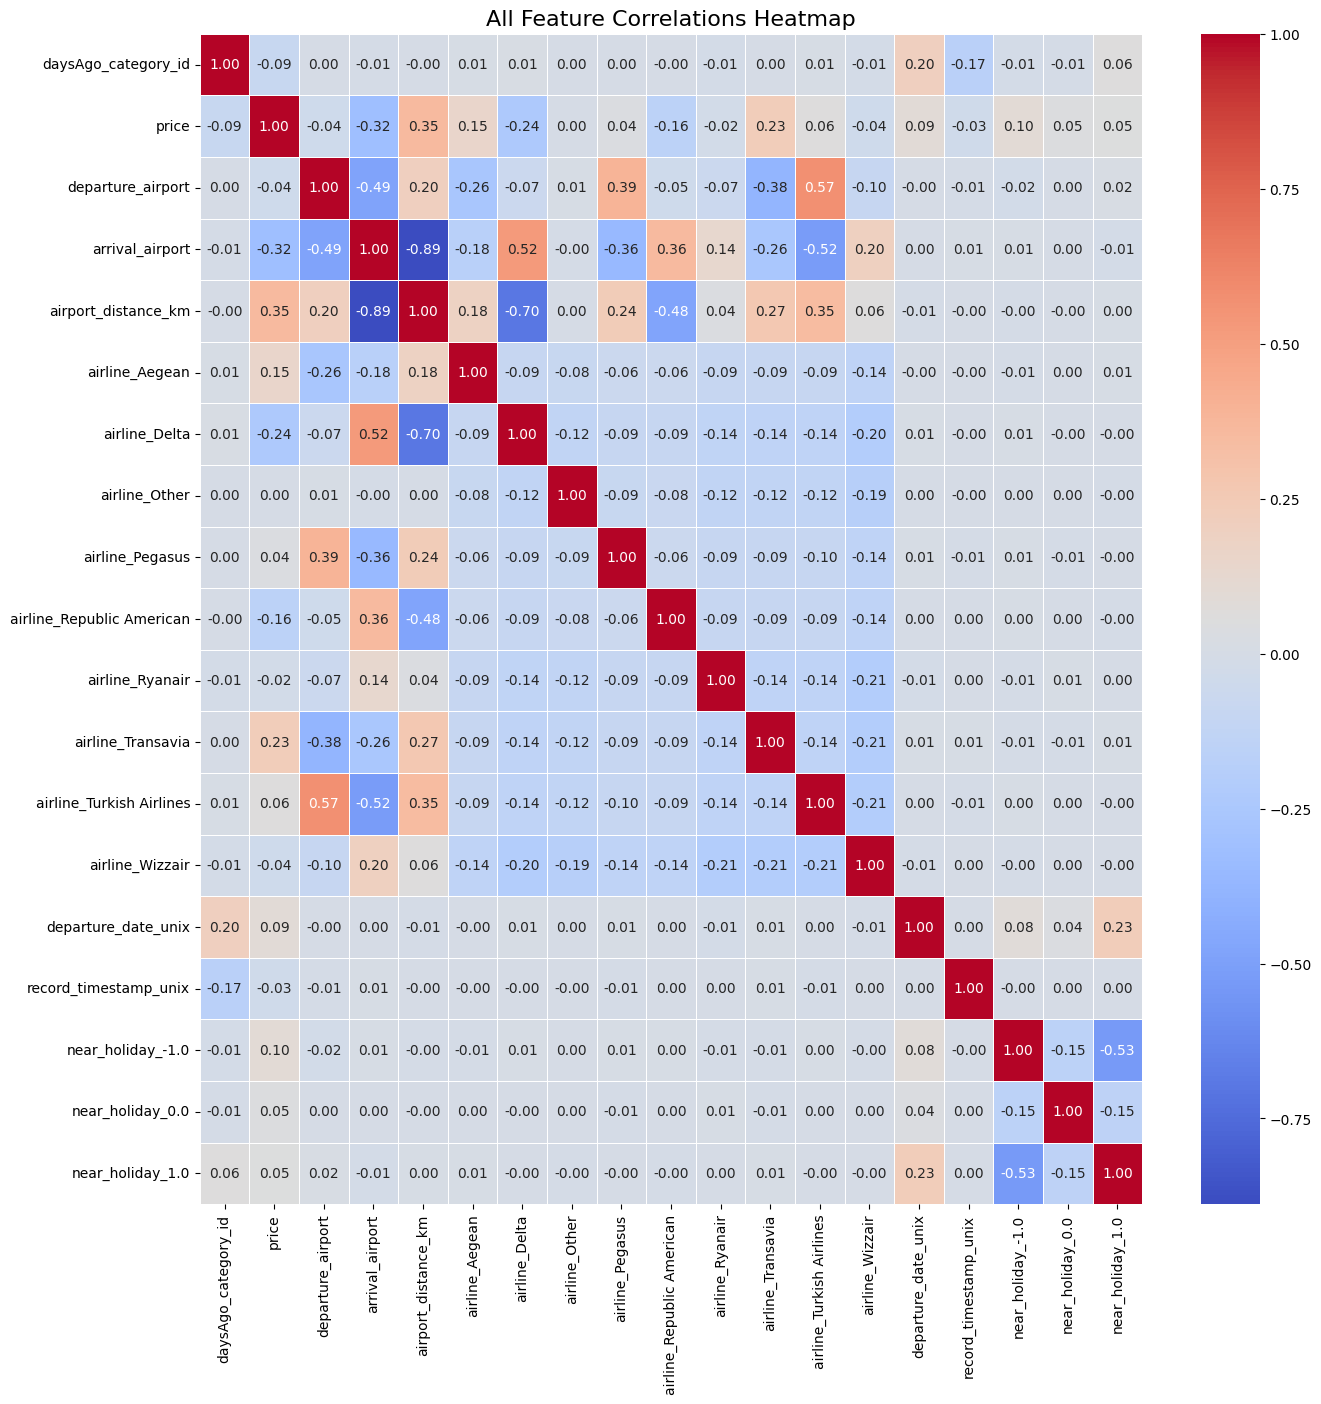

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

correlations = main_data.corr()

plt.figure(figsize=(min(20, 0.8 * len(correlations)), min(20, 0.8 * len(correlations))))  

sns.heatmap(
    correlations, 
    annot=True, 
    fmt=".2f",
    linewidths=0.5,
    cmap="coolwarm",
)

plt.title("All Feature Correlations Heatmap", fontsize=16)
plt.show()

In [10]:
correlation_target = main_data.corr()['daysAgo_category_id'].sort_values(ascending=False)
print(correlation_target)

daysAgo_category_id          1.000000
departure_date_unix          0.203784
near_holiday_1.0             0.057089
airline_Delta                0.011721
airline_Turkish Airlines     0.007222
airline_Aegean               0.005125
airline_Transavia            0.003665
airline_Pegasus              0.003416
departure_airport            0.003347
airline_Other                0.002389
airline_Republic American   -0.001264
airport_distance_km         -0.001932
arrival_airport             -0.006253
near_holiday_0.0            -0.006745
near_holiday_-1.0           -0.010950
airline_Ryanair             -0.011575
airline_Wizzair             -0.014237
price                       -0.087728
record_timestamp_unix       -0.167054
Name: daysAgo_category_id, dtype: float64


We can see that generally the correlations are low, but lets select the ones with highest absolute value

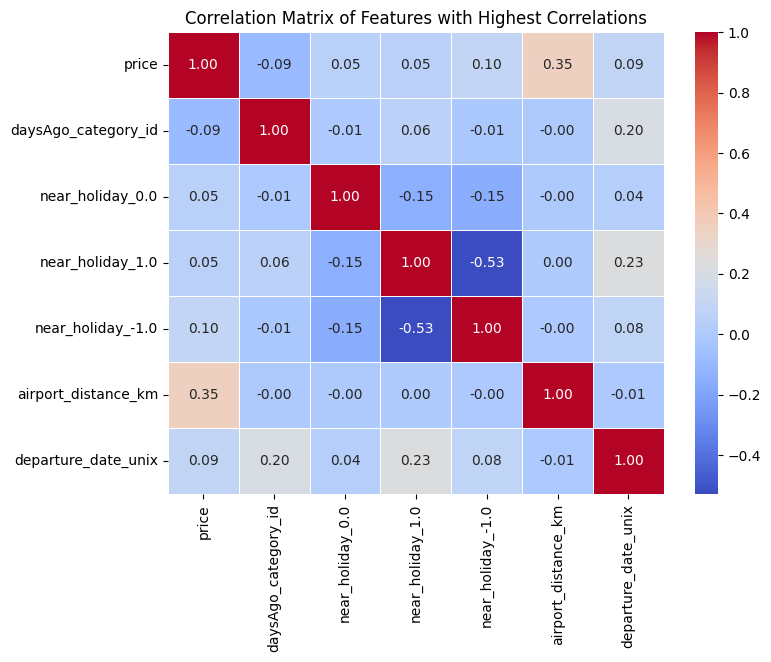

In [11]:
most_important_columns = ['price', 'daysAgo_category_id', 'near_holiday_0.0','near_holiday_1.0','near_holiday_-1.0', 'airport_distance_km', 'departure_date_unix']
correlation_matrix = main_data[most_important_columns].corr()

# Plot heatmap to visualize correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features with Highest Correlations")
plt.show()

In [12]:
correlation_target = correlation_matrix['daysAgo_category_id'].sort_values(ascending=False)
print(correlation_target)

daysAgo_category_id    1.000000
departure_date_unix    0.203784
near_holiday_1.0       0.057089
airport_distance_km   -0.001932
near_holiday_0.0      -0.006745
near_holiday_-1.0     -0.010950
price                 -0.087728
Name: daysAgo_category_id, dtype: float64


We can conclude:
- Price vs. Airport Distance
    - The highest positive correlation is between price and airport_distance_km. This suggests that flights covering longer distances tend to have higher prices, which aligns with common expectations.
- 	Holidays are not a key factor: Despite common beliefs, near_holiday does not have a high correlation with price.

In [13]:
# Define the target and parameters
target = 'daysAgo_category_id'

X = main_data[['price', 'near_holiday_0.0','near_holiday_1.0','near_holiday_-1.0', 'airport_distance_km', 'departure_date_unix']]
y = main_data[target]

### 🪓 Splitting into train/test
80% of the data is used for training, and 20% for testing

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

X_train

There are in total 59996 observations, of which 47996 are now in the train set, and 12000 in the test set.


,price,near_holiday_0.0,near_holiday_1.0,near_holiday_-1.0,airport_distance_km,departure_date_unix
31576,96,False,False,True,2211.947562,1753315200
23571,93,False,True,False,1658.335311,1759017600
26596,135,False,True,False,2211.947562,1746403200
57543,42,False,True,False,328.393017,1756512000
10801,115,False,False,True,2067.423123,1758240000
...,...,...,...,...,...,...
26446,118,False,False,True,2211.947562,1746144000
10409,125,False,True,False,2067.423123,1757635200
36930,62,False,False,False,1658.335311,1743724800
59925,42,False,False,True,328.393017,1759881600


# 🧬 Modelling

`k Nearest Neighbour` will be used at these first stages of the development

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize the KNeighborsRegressor model
knn = KNeighborsClassifier()

# Fit the model on the training data
knn.fit(X_train, y_train)

# Predict the target values on the test set
pred = knn.predict(X_test)

# 🔬 Evaluation
In order to shed some light on the results a classification report can be printed. 

In [16]:

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 0.43216666666666664
Root Mean Squared Error (RMSE): 1.3795530677239882
R² Score: 0.6055561146686614


After many different attempts at data cleaning/changing/adding new features, the KNN does not seem to do a good job on predicting the actual category of the cheapest day, lets switch to a more suitable algorhitm.

## 🆕 Model change -> Linear Regression

Going back to othe original dataset before categorising the target variable

In [17]:
main_data_prepared.sample(10)

main_data = main_data_prepared.copy(deep=True)

## 🎯 Target Variable


Now I will try with the actual and most accurate target variable - daysAgo for a flight

### 💡 Feature Selection


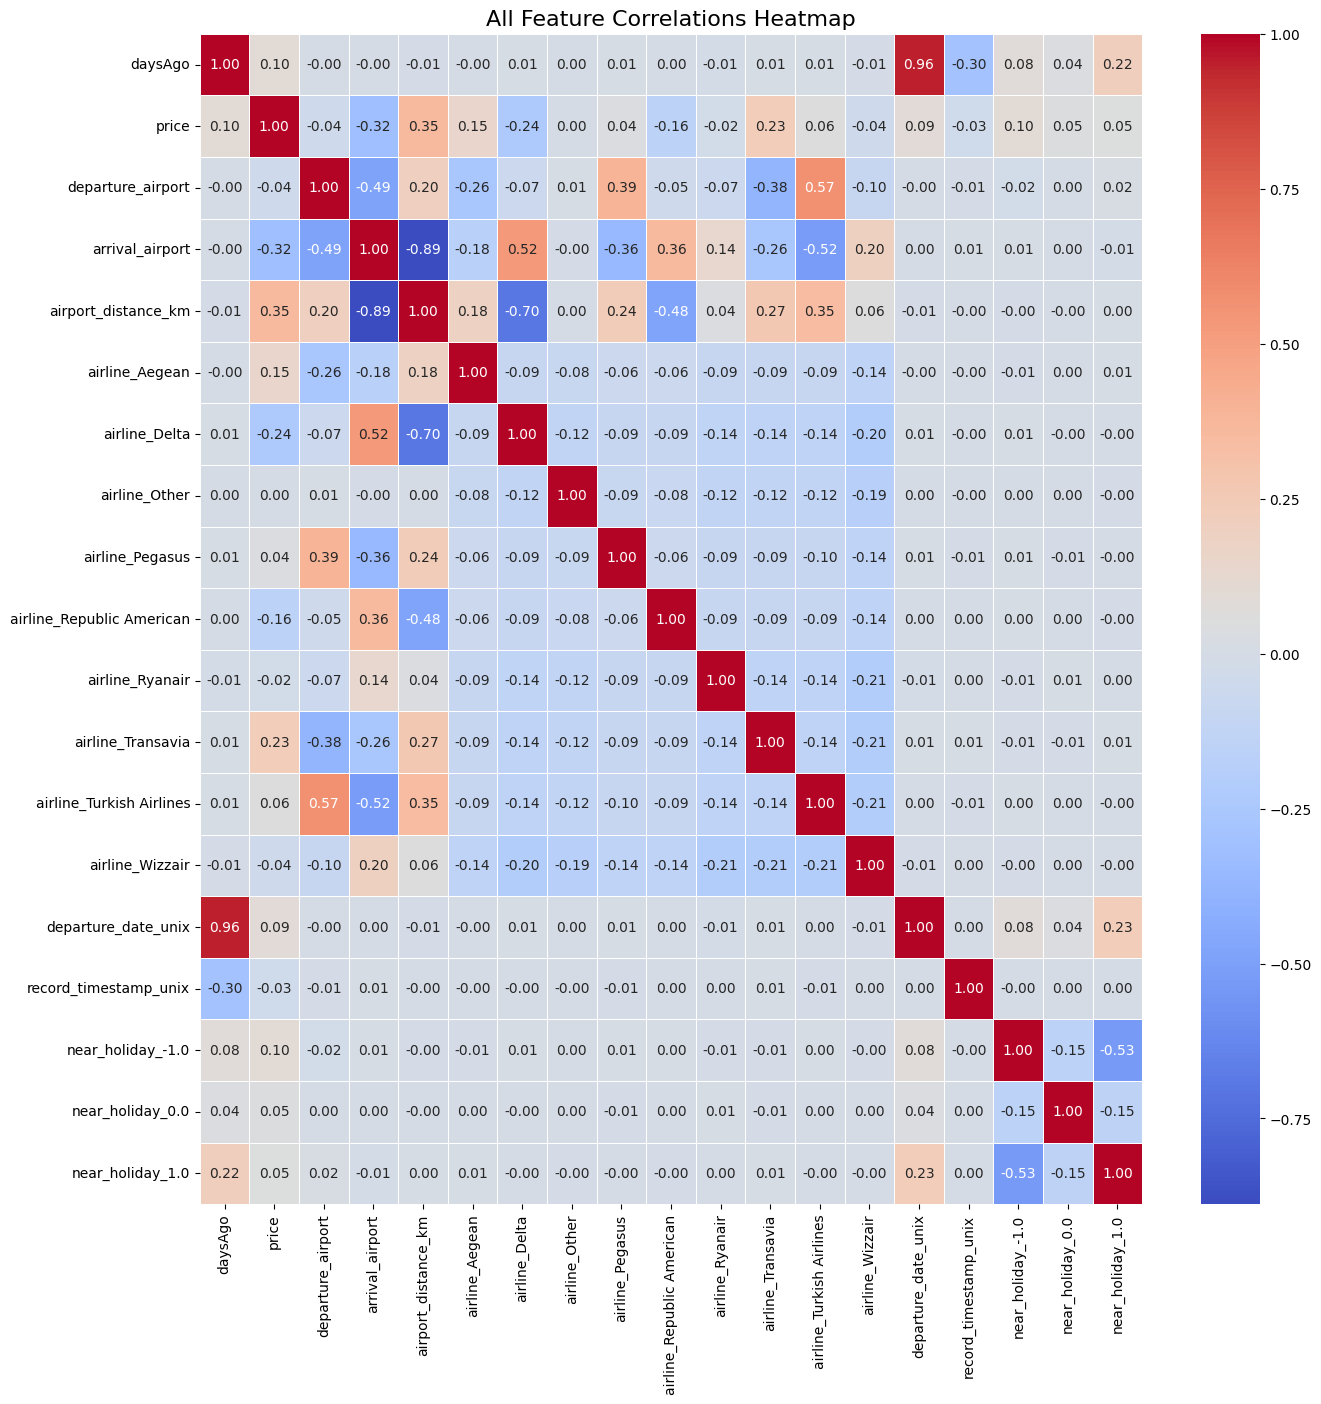

In [18]:
correlations = main_data.corr()

plt.figure(figsize=(min(20, 0.8 * len(correlations)), min(20, 0.8 * len(correlations))))  

sns.heatmap(
    correlations, 
    annot=True, 
    fmt=".2f",
    linewidths=0.5,
    cmap="coolwarm",
)

plt.title("All Feature Correlations Heatmap", fontsize=16)
plt.show()

In [19]:
correlation_target = main_data.corr()['daysAgo']
correlation_target_sorted = correlation_target.reindex(correlation_target.abs().sort_values(ascending=False).index)
print(correlation_target_sorted)

daysAgo                      1.000000
departure_date_unix          0.955349
record_timestamp_unix       -0.295416
near_holiday_1.0             0.215874
price                        0.095231
near_holiday_-1.0            0.078429
near_holiday_0.0             0.035218
airline_Ryanair             -0.013991
airline_Delta                0.010156
airline_Wizzair             -0.009907
airline_Pegasus              0.007640
airline_Transavia            0.005539
airport_distance_km         -0.005304
airline_Turkish Airlines     0.005045
airline_Aegean              -0.002649
airline_Republic American    0.001608
airline_Other                0.001443
arrival_airport             -0.001054
departure_airport           -0.000245
Name: daysAgo, dtype: float64


Now we have greater correlelation between the target and other features, compared to the categorical target variable

Correlation of most important features, where the correlations is above 0.07

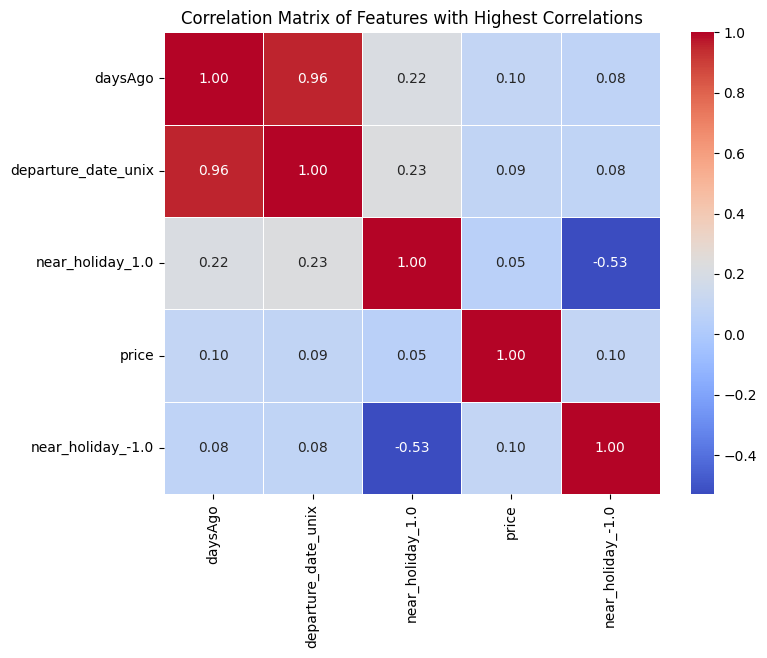

In [20]:
most_important_columns = ['daysAgo', 'departure_date_unix','near_holiday_1.0','price', 'near_holiday_-1.0']
correlation_matrix = main_data[most_important_columns].corr()

# Plot heatmap to visualize correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features with Highest Correlations")
plt.show()

In [21]:
# Define the target and parameters
target = 'daysAgo'
params = ['departure_date_unix', 'record_timestamp_unix','near_holiday_1.0', 'near_holiday_0.0','price', 'near_holiday_-1.0']
X = main_data[most_important_columns]
y = main_data[target]

### 🪓 Splitting into train/test
80% of the data is used for training, and 20% for testing

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

X_train

There are in total 59996 observations, of which 47996 are now in the train set, and 12000 in the test set.


,daysAgo,departure_date_unix,near_holiday_1.0,price,near_holiday_-1.0
59199,193,1758844800,True,50,False
23674,211,1759104000,True,111,False
50456,59,1746230400,False,44,False
2851,66,1746835200,True,68,False
32267,154,1754265600,True,84,False
...,...,...,...,...,...
38572,102,1746144000,False,60,True
54476,132,1752019200,False,44,True
40304,106,1748563200,True,70,False
54781,137,1752451200,True,52,False


# 🧬 Modelling

`Linear Regression` will be used for the iteration 1 attempt

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize the Linear Regression model
lr = LinearRegression()

# Fit the model on the training data
lr.fit(X_train, y_train)

# Predict the target values on the test set
pred = lr.predict(X_test)

# 🔬 Evaluation
In order to shed some light on the results a classification report can be printed. 

In [24]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 6.137867025746146e-11
Root Mean Squared Error (RMSE): 7.077859103057851e-11
R² Score: 1.0


Wow! The R2 Score is 1. The model seems to be very good, however that does not always that the predictions will be correct. Lets test it out

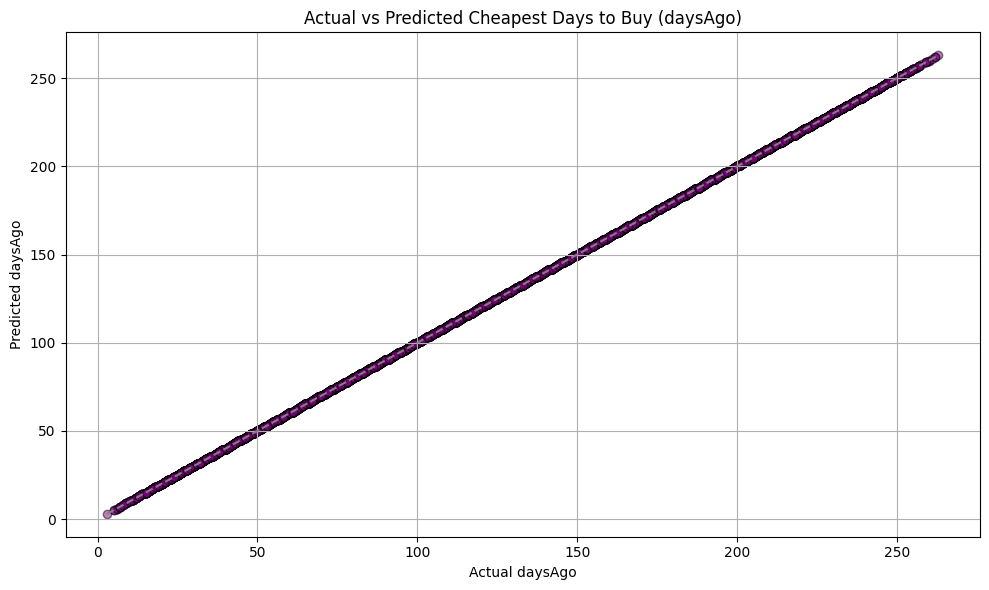

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Scatter plot: Actual vs Predicted
plt.scatter(y_test, pred, alpha=0.5, color='purple', edgecolors='k')

# Add a reference line (perfect predictions)
min_val = min(min(y_test), min(pred))
max_val = max(max(y_test), max(pred))
plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--')

plt.xlabel('Actual daysAgo')
plt.ylabel('Predicted daysAgo')
plt.title('Actual vs Predicted Cheapest Days to Buy (daysAgo)')
plt.grid(True)
plt.tight_layout()
plt.show()

The scatter plot of Actual vs Predicted looks excellent — the points fall almost perfectly on the red dashed line (which represents perfect predictions). This suggests that my model is doing an outstanding job. However, it shouldn't be a straight line, lets keep on testing to see where the problem is.

In [26]:
import pandas as pd

comparison = pd.DataFrame({
    'Actual': y_test[:20],
    'Predicted': pred[:20],
    'Residual': y_test[:20] - pred[:20]
})
print(comparison)

       Actual  Predicted      Residual
89         38       38.0 -1.202096e-10
32890     160      160.0  5.405809e-11
31488     177      177.0  2.680167e-11
11475     241      241.0  1.120668e-10
29044     108      108.0 -2.258105e-11
51322      62       62.0 -5.467626e-11
53         12       12.0 -1.214033e-10
11360     232      232.0  1.096225e-10
30160     123      123.0 -3.268497e-13
12261      29       29.0 -1.214318e-10
27478     103      103.0 -5.348966e-11
58355     231      231.0  9.103474e-11
17398     101      101.0 -1.638512e-11
58674     222      222.0  9.725909e-11
22319     202      202.0  8.367351e-11
13067      29       29.0 -1.053557e-10
48988      67       67.0 -1.054019e-10
7872      186      186.0  3.916512e-11
46663     195      195.0  8.864731e-11
35631     253      253.0  1.095657e-10


The model seems to be outstanding, however I found a big problem

# ⚠️ The Core Issue

My current label (daysAgo) is always the actual day the price was lowest — no matter **WHEN** the user is “checking”.


But what I want is:


“From today (record day), what is the best day still remaining to buy?”
i.e., the minimum price in the future, not including past days.


# Preprocessing again

This function creates a new DataFrame where, for each flight and search date, it labels the future day with the cheapest price among the remaining search days for that specific flight.

In [27]:
def generate_future_cheapest_label(df):
    updated_rows = []
    # Group by unique flights (departure date + airports)
    grouped = df.groupby(['departure_date_unix', 'departure_airport', 'arrival_airport'])

    for _, group in grouped:
        group_sorted = group.sort_values(by='daysAgo', ascending=False).copy()

        prices = group_sorted['price'].tolist()
        days = group_sorted['daysAgo'].tolist()

        for i in range(len(prices) - 1):  # Exclude final row (no future)
            future_prices = prices[i:]
            future_days = days[i:]

            min_idx = np.argmin(future_prices)
            cheapest_remaining_day = future_days[min_idx]

            row = group_sorted.iloc[i].copy()
            row['cheapest_day_future'] = cheapest_remaining_day
            updated_rows.append(row)

    return pd.DataFrame(updated_rows)


In [28]:
main_data_future = generate_future_cheapest_label(main_data_prepared)
main_data_future

,daysAgo,price,departure_airport,arrival_airport,airport_distance_km,airline_Aegean,airline_Delta,airline_Other,airline_Pegasus,airline_Republic American,airline_Ryanair,airline_Transavia,airline_Turkish Airlines,airline_Wizzair,departure_date_unix,record_timestamp_unix,near_holiday_-1.0,near_holiday_0.0,near_holiday_1.0,cheapest_day_future
36375,61,56,0,3,1658.335311,0,0,1,0,0,0,0,0,0,1742515200,1737244800,False,False,False,38
36376,60,56,0,3,1658.335311,0,0,0,0,0,1,0,0,0,1742515200,1737331200,False,False,False,38
36377,59,56,0,3,1658.335311,0,0,0,0,0,0,0,0,1,1742515200,1737417600,False,False,False,38
36378,58,56,0,3,1658.335311,0,0,0,0,0,0,0,0,1,1742515200,1737504000,False,False,False,38
36379,57,46,0,3,1658.335311,0,0,0,0,0,0,0,0,1,1742515200,1737590400,False,False,False,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36369,208,93,3,0,2211.947562,0,0,0,0,0,0,0,1,0,1759968000,1741996800,True,False,False,203
36370,207,88,3,0,2211.947562,0,0,0,1,0,0,0,0,0,1759968000,1742083200,True,False,False,203
36371,206,88,3,0,2211.947562,0,0,0,1,0,0,0,0,0,1759968000,1742169600,True,False,False,203
36372,205,91,3,0,2211.947562,0,0,0,0,0,0,0,1,0,1759968000,1742256000,True,False,False,203


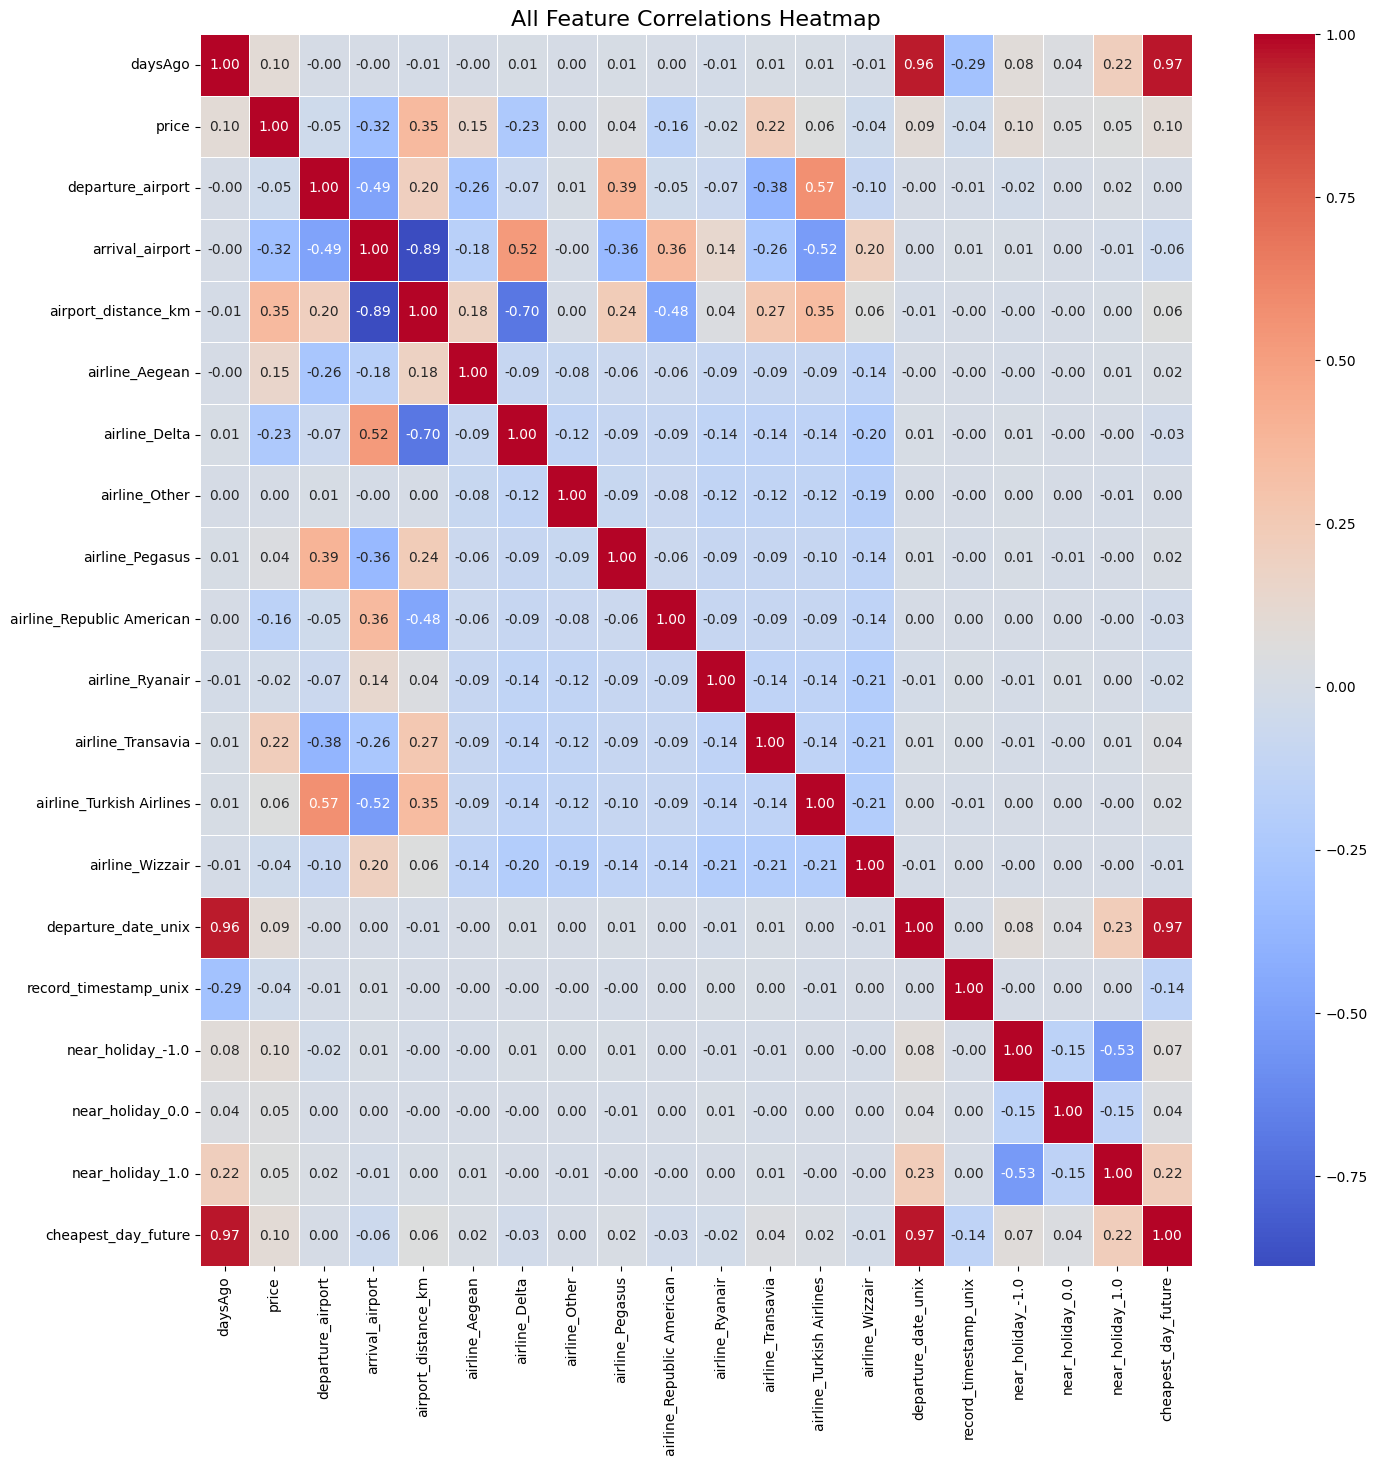

In [29]:
correlations = main_data_future.corr()

plt.figure(figsize=(min(20, 0.8 * len(correlations)), min(20, 0.8 * len(correlations))))  

sns.heatmap(
    correlations, 
    annot=True, 
    fmt=".2f",
    linewidths=0.5,
    cmap="coolwarm",
)

plt.title("All Feature Correlations Heatmap", fontsize=16)
plt.show()

In [30]:
target = 'cheapest_day_future'
params = ['price', 'departure_date_unix', 'record_timestamp_unix',
          'near_holiday_1.0','near_holiday_0.0', 'near_holiday_-1.0', 'airport_distance_km', 'departure_airport', 'arrival_airport']

X = main_data_future[params]
y = main_data_future[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [32]:
comparison_df = pd.DataFrame({
    'Actual': y_test[:10].values,
    'Predicted': np.round(y_pred[:10], 2),
    'Error': y_test[:10].values - np.round(y_pred[:10], 2)
})

print(comparison_df)

   Actual  Predicted  Error
0     201     194.10   6.90
1     222     224.01  -2.01
2      82      92.58 -10.58
3     161     184.50 -23.50
4      67      71.72  -4.72
5     200     212.41 -12.41
6      91      87.09   3.91
7      25      36.17 -11.17
8     110     113.31  -3.31
9      74      69.70   4.30


In [33]:
# Create comparison DataFrame

# Reset index so it's 0 to n
y_test = y_test.reset_index(drop=True)

comparison_df = pd.DataFrame({
    'Actual': y_test[:10],
    'Predicted': np.round(y_pred[:10], 2),
    'Error': y_test[:10] - np.round(y_pred[:10], 2)
})

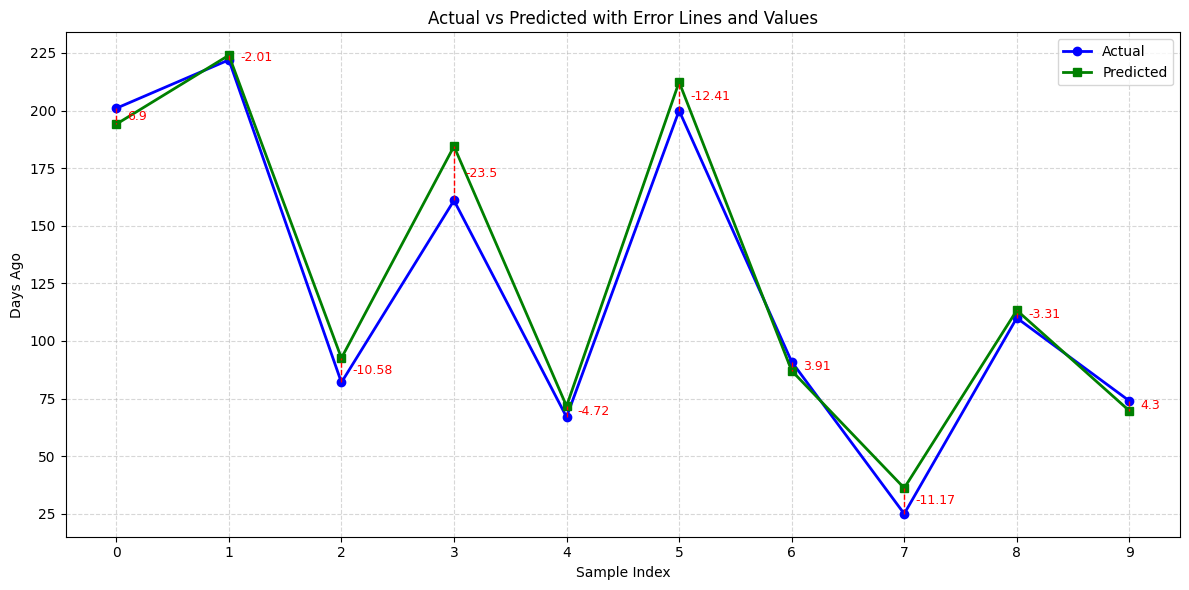

In [34]:
plt.figure(figsize=(12, 6))

# Use the numeric index directly
x = comparison_df.index

# Plot Actual and Predicted
plt.plot(x, comparison_df['Actual'], label='Actual', color='blue', marker='o', linewidth=2)
plt.plot(x, comparison_df['Predicted'], label='Predicted', color='green', marker='s', linewidth=2)

# Draw red error lines and annotate them
for i in x:
    actual = comparison_df['Actual'].iloc[i]
    predicted = comparison_df['Predicted'].iloc[i]
    plt.plot([i, i], [actual, predicted], color='red', linestyle='--', linewidth=1)
    mid_y = (actual + predicted) / 2
    error_val = round(actual - predicted, 2)
    plt.text(i + 0.1, mid_y, f'{error_val}', color='red', fontsize=9, ha='left', va='center')

# Style the plot
plt.title('Actual vs Predicted with Error Lines and Values')
plt.xlabel('Sample Index')
plt.ylabel('Days Ago')
plt.xticks(x)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Conclusion:
- 	The model is generally accurate, with most predicted values closely following the actual values
- The predicted line (green) follows the trend of the actual line (blue), indicating the model captures the overall behavior well
- Most prediction errors are within ±10 days, which is reasonable for predicting when flight prices are cheapest

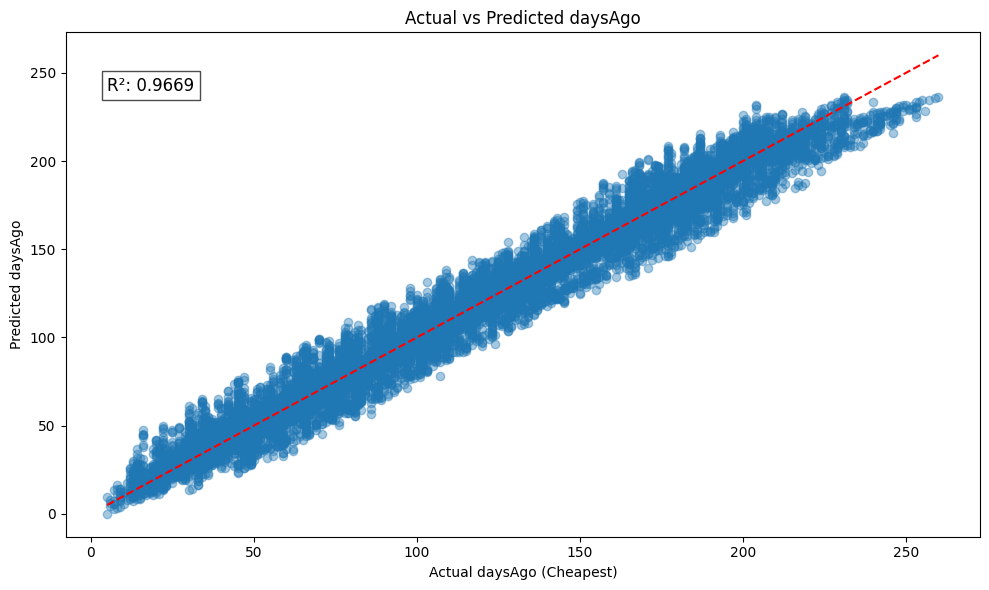

In [35]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)

# Plot Actual vs Predicted with metrics
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual daysAgo (Cheapest)")
plt.ylabel("Predicted daysAgo")
plt.title("Actual vs Predicted daysAgo")

# Add metrics to the plot
plt.text(5, y_test.max() - 20, f"R²: {r2:.4f}", 
         fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

The model does a great job of predicting the number of days in advance someone should buy a ticket to get the cheapest price. This plot visually confirms that the predictions are close to the actual values, with minimal error.

Slight deviation at the top end: At higher daysAgo values (above ~200), predictions start to underestimate a bit, which might be due to:
- Fewer data points in that range.
-	Reduced variability in ticket price changes far in advance.

📌 Next steps you can try in Iteration 2:
- Make it so it predicts a few possible lowest prices dates to a flight and the user manually checks which one is the best
- Inference - To see if the model actually predicts correct results based on user data

- Maybe in Iteration 3: XGBoost: It handles nonlinear patterns way better and could fix the overshooting issue.


In [36]:
from datetime import datetime
import time
import numpy as np

# Example: today's date = April 4, 2025
today_unix = int(time.mktime(datetime(2025, 4, 4).timetuple()))

# Example: user checks a flight from Eindhoven to Sofia, departs on April 20
departure_date_unix = int(time.mktime(datetime(2025, 4, 20).timetuple()))

# Simulate features
sample_input = pd.DataFrame([{
    'airport_distance_km': 1200,
    'arrival_airport': 5,  # encoded value
    'departure_airport': 3,  # encoded value
    'departure_date_unix': departure_date_unix,
    'near_holiday_-1.0': False,
    'near_holiday_0.0': True,
    'near_holiday_1.0': False,
    'price': 89,
    'record_timestamp_unix': today_unix
}])
sample_input = sample_input[model.feature_names_in_] # Order the columns as the training data
# Predict
predicted_days_before = model.predict(sample_input)[0]
days_before_rounded = int(round(predicted_days_before))

# Output
print(f"🎯 Recommended day to buy: {days_before_rounded} days before departure")
best_date = datetime.fromtimestamp(departure_date_unix - days_before_rounded * 86400)
print(f"📆 That means: {best_date.strftime('%Y-%m-%d')}")


🎯 Recommended day to buy: 18 days before departure
📆 That means: 2025-04-02
